In [1]:
# importing the necessary packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from datetime import datetime as dt

In [2]:
# loading the data frame and converting attiributes to object type or datetime.
listings = pd.read_csv('../data/listings_clean.csv')
# converting data type to datetime.
listings[['host_since', 'calendar_last_scraped','first_review','last_review']] = listings[['host_since', 'calendar_last_scraped','first_review','last_review']].apply(pd.to_datetime)
# changing data type of is,host_id columns to object
listings[['id','host_id']] = listings[['id','host_id']].astype('object')
listings.select_dtypes('object').info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6883 entries, 0 to 6882
Data columns (total 10 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   id                      6883 non-null   object
 1   host_id                 6883 non-null   object
 2   host_response_time      5021 non-null   object
 3   host_verifications      6883 non-null   object
 4   neighbourhood           4938 non-null   object
 5   neighbourhood_cleansed  6883 non-null   object
 6   property_type           6883 non-null   object
 7   room_type               6883 non-null   object
 8   amenities               6883 non-null   object
 9   license                 3878 non-null   object
dtypes: object(10)
memory usage: 537.9+ KB


**Summary:**

There are 10 columns that are in object type. I will keep id and host_id columns as object type. I looked into the remaining columns and here what I will do for them:

1. Did ordinal encoder for the host_response_time. 
2. Processed the host_verifications column and converted entries into a list and encoded using MultiLabelBinarizer.
3. Dropped the neighbourhood column since it encodes for large cities/areas that would not provide detailed information.
4. Renamed neighbourhood_cleansed column as neighbourhood and encoded using pd.get_dummies().
5. Dropped the property_type column since it contains subgroups of room_type such as entire_home_bungalow etc. 
6. room_type was encoded using pd.get_dummies()
7. Processed the amenities column and converted entries into a list and encoded using MultiLabelBinarizer. There are ~600 labels after this conversion. These entries as amenities could be reduced by combining them using string operations which involves a lot of manual labor. Instead of doing this, I decided to create a new feature by counting the number of features for each listing.
8. Created a new feature from host_since column as years_as_host.
9. Dropped host_listings_count, host_total_listings_count: Wrong information, confirmed by filtering based host_id. calculated_host_listings_count contains the correct value.
10. Dropped licence, calendar_last_scraped columns, has_availability columns.
    * licence: not sure if it is relevant information
    * calendar_last_scraped: not sure if it is relevant information
    * has_availability: it is 1,0 depending on the availability at the day of scraping.
11. Converted first_review and last_review into months. They are both date_time objects and I converted into new columns as first_review_since_months and last_review_since_months.
12. Dropped minimum_minimum_nights, maximum_minimum_nights, minimum_maximum_nights, maximum_maximum_nights, minimum_nights_avg_ntm, maximum_nights_avg_ntm

In [3]:
listings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6883 entries, 0 to 6882
Data columns (total 57 columns):
 #   Column                                        Non-Null Count  Dtype         
---  ------                                        --------------  -----         
 0   id                                            6883 non-null   object        
 1   host_id                                       6883 non-null   object        
 2   host_since                                    6868 non-null   datetime64[ns]
 3   host_response_time                            5021 non-null   object        
 4   host_response_rate                            5021 non-null   float64       
 5   host_acceptance_rate                          5517 non-null   float64       
 6   host_is_superhost                             6868 non-null   float64       
 7   host_listings_count                           6868 non-null   float64       
 8   host_total_listings_count                     6868 non-null   float6

In [4]:
# checking the unique values in the host_response_time.
listings.host_response_time.unique()

array(['within an hour', 'within a few hours', nan, 'within a day',
       'a few days or more'], dtype=object)

* I can order these entries as:  
within an hour < within a few hours < within a day < a few days or more

* I will use ordinal encoder for this variable.


In [5]:
response_time_dict = {'within an hour':1, 'within a few hours':2, 'within a day':3, 'a few days or more':4 }
listings['host_response_time_ordinal'] = listings.host_response_time.map(response_time_dict)
listings = listings.drop('host_response_time',axis=1)

In [6]:
# let's check the host_verifications column.
listings[['host_verifications']].head()

,host_verifications
0,"['email', 'phone', 'facebook', 'reviews', 'kba']"
1,"['email', 'phone', 'reviews', 'kba', 'work_ema..."
2,"['email', 'phone', 'reviews', 'jumio', 'govern..."
3,"['email', 'phone', 'reviews', 'jumio', 'govern..."
4,"['email', 'phone', 'reviews', 'kba']"


Host verifications column contains a list of verification methods. First of all I need to check if each row contains a list or is it string. 

In [7]:
print(type(listings['host_verifications'][0]))
print(listings['host_verifications'][0])

<class 'str'>
['email', 'phone', 'facebook', 'reviews', 'kba']


I need to split each of these verification methods and create a list out of them. I will use comma as splitting criteria, but before that I need to get rid of all non-letter characters except comma.

In [8]:
for l in ['[',']',' ',"'"]:
    listings['host_verifications'] = listings.host_verifications.str.replace(l,'')
listings['host_verifications'] = listings.host_verifications.str.split(',')

/Users/dagdasy/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will*not* be treated as literal strings when regex=True.
  


In [9]:
# Confirming that unnecessary characters are removed and entries are converted to a list.
print(listings['host_verifications'][0])
print(type(listings['host_verifications'][0]))

['email', 'phone', 'facebook', 'reviews', 'kba']
<class 'list'>


I will convert these into labels using MultiLabelBinarizer.

In [10]:
from sklearn.preprocessing import MultiLabelBinarizer

mlb = MultiLabelBinarizer(sparse_output=True)

listings = listings.join(
            pd.DataFrame.sparse.from_spmatrix(
                mlb.fit_transform(listings.pop('host_verifications')),
                index=listings.index,
                columns='host_ver_' + mlb.classes_))

In [11]:
listings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6883 entries, 0 to 6882
Data columns (total 73 columns):
 #   Column                                        Non-Null Count  Dtype           
---  ------                                        --------------  -----           
 0   id                                            6883 non-null   object          
 1   host_id                                       6883 non-null   object          
 2   host_since                                    6868 non-null   datetime64[ns]  
 3   host_response_rate                            5021 non-null   float64         
 4   host_acceptance_rate                          5517 non-null   float64         
 5   host_is_superhost                             6868 non-null   float64         
 6   host_listings_count                           6868 non-null   float64         
 7   host_total_listings_count                     6868 non-null   float64         
 8   host_has_profile_pic                          68

In [12]:
# lets check the neighbourhood column
listings.neighbourhood.unique()

array(['San Francisco, California, United States', nan,
       'San Francisco, Hayes Valley, California, United States',
       'Noe Valley - San Francisco, California, United States',
       'Daly City, California, United States',
       'San Franscisco, California, United States',
       'San Jose, California, United States',
       'San Francisco , Ca, United States'], dtype=object)

neighbourhood column is too broad. I will check the neighbourhood_cleansed column. If there is detailed information in it then I will drop the first and use the latter.

In [13]:
# lets check the neighbourhood_cleansed column
listings.neighbourhood_cleansed.unique()

array(['Western Addition', 'Bernal Heights', 'Haight Ashbury', 'Mission',
       'Nob Hill', 'Downtown/Civic Center', 'Castro/Upper Market',
       'Noe Valley', 'Twin Peaks', 'Potrero Hill', 'Outer Richmond',
       'Glen Park', 'Ocean View', 'Pacific Heights', 'Financial District',
       'Inner Sunset', 'Russian Hill', 'Outer Sunset', 'Marina',
       'Inner Richmond', 'Excelsior', 'Seacliff', 'West of Twin Peaks',
       'Bayview', 'North Beach', 'Presidio', 'Presidio Heights',
       'Diamond Heights', 'Chinatown', 'Parkside', 'South of Market',
       'Outer Mission', 'Lakeshore', 'Crocker Amazon', 'Golden Gate Park',
       'Visitacion Valley'], dtype=object)

In [14]:
#Dropping the neighbourhood column
listings = listings.drop('neighbourhood',axis=1)

neighbourhood_cleansed column has detailed information that could separate "good" neighbourhoods from the "bad" ones which could impact the pricing of the listings.
I will use get_dummies to create the labels.

In [15]:
listings = pd.get_dummies(listings, prefix='neighbourhood', prefix_sep='_', dummy_na=False, columns=['neighbourhood_cleansed'], sparse=False, drop_first=False, dtype=None)

In [16]:
# let's check the property_type column.
listings.property_type.unique()

array(['Entire apartment', 'Private room in apartment',
       'Entire condominium', 'Private room in condominium',
       'Entire house', 'Private room in townhouse', 'Entire loft',
       'Private room in house', 'Entire guest suite', 'Entire cottage',
       'Private room in cottage', 'Shared room in hostel',
       'Private room in hostel', 'Private room in guest suite',
       'Entire guesthouse', 'Shared room in house', 'Entire bungalow',
       'Entire townhouse', 'Shared room in apartment',
       'Shared room in loft', 'Private room in bed and breakfast',
       'Entire serviced apartment', 'Room in hotel',
       'Room in boutique hotel', 'Shared room in bed and breakfast',
       'Private room in loft', 'Room in serviced apartment',
       'Private room in villa', 'Barn', 'Room in aparthotel',
       'Entire floor', 'Private room in resort',
       'Private room in serviced apartment', 'Private room in bungalow',
       'Shared room in townhouse', 'Private room', 'Entire pla

This looks like a subset of room_type column. I will drop this column completely and use room_type information for the model.


In [17]:
# let's check the room_type column.
listings.room_type.unique()

array(['Entire home/apt', 'Private room', 'Shared room', 'Hotel room'],
      dtype=object)

In [18]:
# Encoding the labels using get_dummies()
listings = pd.get_dummies(listings, prefix='room_type', prefix_sep='_', dummy_na=False, columns=['room_type'], sparse=False, drop_first=False, dtype=None)

In [19]:
# Dropping the property_type column
listings = listings.drop('property_type', axis=1)

In [20]:
# let's check the amenities column.
listings[['amenities']].head()

,amenities
0,"[""Hangers"", ""Essentials"", ""Oven"", ""Free street..."
1,"[""Essentials"", ""Wifi"", ""Private entrance"", ""De..."
2,"[""Lock on bedroom door"", ""Hot water"", ""Private..."
3,"[""Lock on bedroom door"", ""Hot water"", ""Private..."
4,"[""Free street parking"", ""Hair dryer"", ""Heating..."


* I will repeat same procedure I used for host_verifications for the amenities column.

In [21]:
# Creating a new data frame using amenities column.
# Removing the extra characters and converting the entries to a list
df_amenities = listings[['amenities']]

for l in ['[',']',' ','"']:
    df_amenities['amenities'] = df_amenities.amenities.str.replace(l,'')
df_amenities['amenities'] = df_amenities.amenities.str.split(',')

/Users/dagdasy/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will*not* be treated as literal strings when regex=True.
  
/Users/dagdasy/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/dagdasy/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-vi

In [22]:
# Confirming that unnecessary characters are removed and entries are converted to a list.
print(df_amenities['amenities'][0])
print(type(df_amenities['amenities'][0]))

['Hangers', 'Essentials', 'Oven', 'Freestreetparking', 'Coffeemaker', 'CableTV', 'Pack\\u2019nPlay/travelcrib', 'TV', 'Refrigerator', 'Dedicatedworkspace', 'Room-darkeningshades', 'Kitchen', 'Washer', 'Longtermstaysallowed', 'Heating', 'Microwave', 'Dryer', 'Keypad', 'Shampoo', 'Iron', 'Gardenorbackyard', 'Hotwater', 'Stove', 'Wifi', 'Firstaidkit', 'Carbonmonoxidealarm', 'Hairdryer', 'Dishesandsilverware', 'Smokealarm', 'Cookingbasics', 'Privateentrance']
<class 'list'>


In [23]:
mlb = MultiLabelBinarizer(sparse_output=True)

df_amenities = df_amenities.join(
            pd.DataFrame.sparse.from_spmatrix(
                mlb.fit_transform(df_amenities.pop('amenities')),
                index=df_amenities.index,
                columns='amenities' + mlb.classes_))

In [24]:
#Checking how many labels are created:
df_amenities.shape

(6883, 522)

* There are 522 amenities. Are they really different or are they very same amenities but are being recognized as different due to slight changes in string

In [25]:
set(df_amenities.columns)

{'amenities',
 'amenities120\\TVwithAmazonPrimeVideo',
 'amenities1space',
 'amenities28\\HDTVwithAmazonPrimeVideo',
 'amenities32\\HDTVwithAmazonPrimeVideo',
 'amenities32\\TV',
 'amenities37\\HDTVwithNetflix',
 'amenities3MinuteMiracleMoistconditioner',
 'amenities40\\HDTVwithRoku',
 'amenities40\\TV',
 'amenities42\\HDTVwithAppleTV',
 'amenities42\\HDTVwithChromecast',
 'amenities42\\HDTVwithHBOMax',
 'amenities42\\HDTVwithNetflix',
 'amenities42\\HDTVwithpremiumcable',
 'amenities43\\HDTV',
 'amenities44\\HDTVwithAmazonPrimeVideo',
 'amenities46\\HDTV',
 'amenities46\\HDTVwithNetflix',
 'amenities47\\HDTVwithNetflix',
 'amenities49\\HDTVwithChromecast',
 'amenities4burnersanddoubleovenelectroniccontrolstainlesssteelgasstove',
 'amenities5-10yearsold',
 'amenities50\\HDTV',
 'amenities50\\HDTVwithNetflix',
 'amenities50\\HDTVwithRoku',
 'amenities52\\HDTVwithstandardcable',
 'amenities55\\HDTV',
 'amenities55\\HDTVwithAmazonPrimeVideo',
 'amenities55\\HDTVwithChromecast',
 'amenitie

* There are number of column names that are very similar to each other. Hosts have entered HDTV with >30 different ways. 55' TV vs 65' TV or Netflix vs Amazon Prime video would not make a big difference in terms of choosing one listing over the other. So I do not think that they would have an impact on the pricing of the listing. It requires manual labor to combine these amenities into one. 

* Instead, I decided to create a new feature using amenities. I will use number of amenities per listing as a feature.

In [26]:
# Removing the extra characters and converting the entries to a list

for l in ['[',']',' ','"']:
    listings['amenities'] = listings.amenities.str.replace(l,'')
listings['amenities'] = listings.amenities.str.split(',')

/Users/dagdasy/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will*not* be treated as literal strings when regex=True.
  after removing the cwd from sys.path.


In [27]:
listings['num_of_amenities'] = listings['amenities'].apply(lambda x: len(x))

In [28]:
listings['num_of_amenities'].head()

0    31
1    16
2    16
3    15
4    26
Name: num_of_amenities, dtype: int64

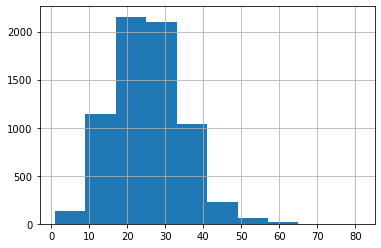

In [29]:
# Checking the distribution of amenities per listing.
listings['num_of_amenities'].hist();

In [30]:
# Calculating how many years have passed as a host.
listings['years_as_host'] = (pd.Timestamp.now() - listings['host_since']).dt.days/365.25
#dropping the host_since column.
listings = listings.drop('host_since', axis=1)

In [31]:
# getting a glance at 'id','host_id','host_listings_count','host_total_listings_count','calculated_host_listings_count' columns.
listings[['id','host_id','host_listings_count','host_total_listings_count','calculated_host_listings_count']].sort_values('calculated_host_listings_count',ascending=False)

,id,host_id,host_listings_count,host_total_listings_count,calculated_host_listings_count
4855,36508250,107434423,1401.0,1401.0,177
5411,39886447,107434423,1401.0,1401.0,177
5413,39886593,107434423,1401.0,1401.0,177
5418,39911005,107434423,1401.0,1401.0,177
6710,47325832,107434423,1401.0,1401.0,177
...,...,...,...,...,...
2792,21233544,1852503,1.0,1.0,1
2794,21242955,153547987,1.0,1.0,1
2795,21252479,8357805,1.0,1.0,1
2797,21267987,764782,1.0,1.0,1


Based on this the host with host_id = 107434423 has 177 listings. However, host_listing_counts and host_total_listings_count has different values. To check which column has correct information I will filter the data frame using the host_id and check the listings count.

In [32]:
# Filtering the data frame using host_id = 107434423
rows, columns = listings.query('host_id == 107434423').shape
print('The host with host_id = 107434423 has ', rows, ' listings in total')

The host with host_id = 107434423 has  177  listings in total


Based on this result I will drop the host_listing_counts and host_total_listings_count columns along with other columns I mentioned in the summary section above.

In [33]:
listings = listings.drop(['host_listings_count','host_total_listings_count','license','calendar_last_scraped','has_availability','minimum_minimum_nights', 'maximum_minimum_nights', 'minimum_maximum_nights', 'maximum_maximum_nights', 'minimum_nights_avg_ntm', 'maximum_nights_avg_ntm'], axis=1)

Converted first_review and last_review into months. They are both date_time objects and I converted into new columns as first_review_since_months and last_review_since_months.



In [34]:
# Calculating how many months have passed since first and last review entered.
listings['first_review_since_in_months'] = (pd.Timestamp.now() - listings['first_review']).dt.days/30
listings['last_review_since_in_months'] = (pd.Timestamp.now() - listings['last_review']).dt.days/30
#dropping the first_review and last_review columns.
listings = listings.drop(['first_review','last_review'], axis=1)

In [35]:
listings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6883 entries, 0 to 6882
Data columns (total 99 columns):
 #   Column                                        Non-Null Count  Dtype           
---  ------                                        --------------  -----           
 0   id                                            6883 non-null   object          
 1   host_id                                       6883 non-null   object          
 2   host_response_rate                            5021 non-null   float64         
 3   host_acceptance_rate                          5517 non-null   float64         
 4   host_is_superhost                             6868 non-null   float64         
 5   host_has_profile_pic                          6868 non-null   float64         
 6   host_identity_verified                        6868 non-null   float64         
 7   latitude                                      6883 non-null   float64         
 8   longitude                                     68

In [36]:
listings.to_csv(r'../data/listings_premodel.csv', index = False, header=True)